# File information
File: Assignment12.ipynb

Name: Amie Davis

Date: 2/28/2021

Course: DSC650 - Big Data

Assignment Number: 12

Purpose: Implement a variational autoencoder (VAE)

# References:

Chollet, F. (2018). Deep learning with Python. Shelter Island, NY: Manning Publications.

https://www.tensorflow.org/datasets/catalog/celeb_a

https://www.kaggle.com/kumar1541/variational-auto-encoder-in-keras

http://airobott.blogspot.com/2020/05/how-to-generate-faces-using-vae-with.html

# Assignment 12
Using section 8.4 in Deep Learning with Python as a guide, implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the results/vae directory. If you would rather work on a more interesting dataset, you can use the CelebFaces Attributes Dataset instead. 

## MNIST Dataset

In [1]:
# VAE encoder network 
# Encodes the input into a mean and variance parameter

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16

# Dimensionality of the latent space is a 2D plane
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)


# The input image is encoded into these two parameters.
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.
C:\Users\amomu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amomu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amomu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amomu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Latent-space-sampling function
# Draws a latent point using a small random epsilon

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [3]:
# VAE decoder network, mapping latent space points to images 

# Decode z back to an image
# Input where you’ll feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape z into a feature map of the same shape as the feature map 
# just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)

# Use Conv2DTranspose layer and Conv2D layer to decode z into a feature map 
# the same size as the original image input
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# Instantiate the decoder model, which turns “decoder_input” into the decoded image
decoder = Model(decoder_input, x)

# Recover the decoded z
z_decoded = decoder(z)

In [4]:
#  Custom layer used to compute the VAE loss 
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # Implement custom layers by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        # Note that x is not used
        return x

# Call the custom layer on the input and the decoded output to obtain the final model output
y = CustomVariationalLayer()([input_img, z_decoded])

In [5]:
# Training the VAE on the mnist dataset
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

C:\Users\amomu\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [6]:
# Create results directory
import os
from pathlib import Path

current_dir=Path(os.getcwd()).absolute()

results_dir=current_dir.joinpath('results')
results_dir.mkdir(parents=True, exist_ok=True)

vae_dir=results_dir.joinpath('vae')
vae_dir.mkdir(parents=True, exist_ok=True)

mnist_out_plot=vae_dir.joinpath('mnist_vae_ouput.png')

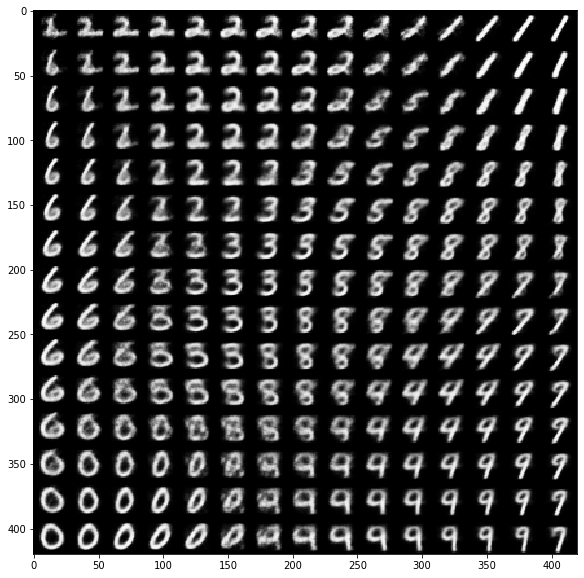

In [7]:
# Sampling a grid of points from the 2D latent space and decoding them to images
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a grid of 15 × 15 digits (255 digits total).
n = 15

digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Transforms linearly spaced coordinates using the SciPy ppf function 
# to produce values of the latent variable z (because the prior of the latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        
        # Repeats z multiple times to form a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        # Decodes the batch into digit images
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        # Reshapes the first digit in the batch from 28 × 28 × 1 to 28 × 28
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

# Save figure
plt.savefig(mnist_out_plot)


## CelebFaces Dataset

In [8]:
# Prepare the CelebFaces Attributes Dataset (CelebA)
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dir_data      = celeba_dir = os.path.join(current_dir, 'archive\img_align_celeba\img_align_celeba')

# Use 20,000 images to train & 100 to test
Ntrain        = 20000 
Ntest         = 100

nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (32, 32, 3)

# Shrink the image size to save computation time
def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (20000, 32, 32, 3)
X_test.shape = (100, 32, 32, 3)


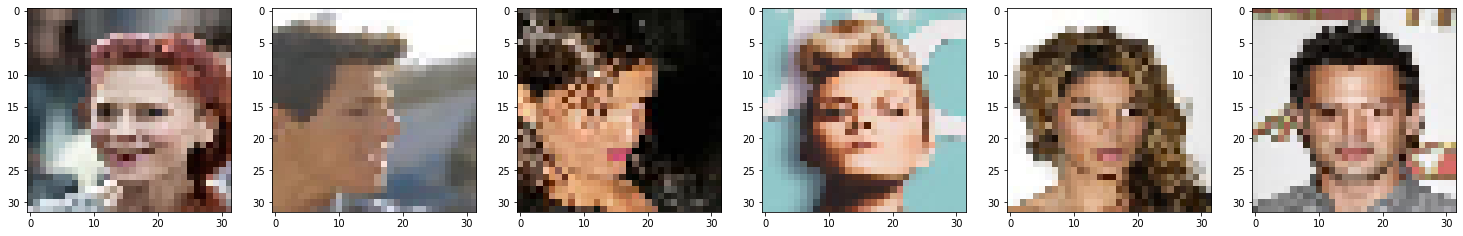

In [9]:
# Plot resized input images
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

In [10]:
# VAE encoder network 
# Encodes the input into a mean and variance parameter

# Rebuild since image size changed to 32 x 32 x 3
img_shape = (32, 32, 3)
batch_size = 16

# AMD
latent_dim = 128

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, (2,2),
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, (2,2),
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, (2,2),
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, (2,2),
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# The input image is encoded into these two parameters.
z_mean = layers.Dense(latent_dim, activation='relu')(x)
z_log_var = layers.Dense(latent_dim, activation='relu')(x)

In [11]:
# Latent-space-sampling function
# Draws a latent point using a small random epsilon

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img,z,name = "VAE_Encoder")
encoder.summary()

Model: "VAE_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   416         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   8256        conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   16448       conv2d_7[0][0]                   
________________________________________________________________________________________

In [12]:
# VAE decoder network, mapping latent space points to images 

# Decode z back to an image
# Input where you’ll feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape z into a feature map of the same shape as the feature map 
# just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32,(3,3),
                           padding='same',
                           activation='relu',
                           strides=2)(x)

# Use Conv2DTranspose layer and Conv2D layer to decode z into a feature map 
# the same size as the original image input
x = layers.Conv2D(3, (3,3),
                  padding='same',
                  activation='sigmoid')(x)

# Instantiate the decoder model, which turns “decoder_input” into the decoded image
decoder = Model(decoder_input, x)

# Recover the decoded z
z_decoded = decoder(z)

In [13]:
#  Custom layer used to compute the VAE loss 
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # Implement custom layers by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        # Note that x is not used
        return x

# Call the custom layer on the input and the decoded output to obtain the final model output
y = CustomVariationalLayer()([input_img, z_decoded])

#AMD
print("y shape = {}".format(x.shape))

y shape = (?, ?, ?, 3)


In [14]:
# Training the VAE on the CelebFaces Attributes Dataset (CelebA)
vae2 = Model(input_img, y)
vae2.compile(optimizer='rmsprop', loss=None)
vae2.summary()

vae2.fit(x=X_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_test, None))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   416         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   8256        conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   16448       conv2d_7[0][0]                   
____________________________________________________________________________________________

C:\Users\amomu\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_2.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 20000 samples, validate on 100 samples
Epoch 1/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.5681 - val_loss: 0.5348
Epoch 2/10
20000/20000 [==============================] - 123s 6ms/step - loss: 0.5382 - val_loss: 0.5326
Epoch 3/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.5316 - val_loss: 0.5208
Epoch 4/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.5282 - val_loss: 0.5259
Epoch 5/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.5261 - val_loss: 0.5174
Epoch 6/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.5245 - val_loss: 0.5162
Epoch 7/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.5231 - val_loss: 0.5158
Epoch 8/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.5221 - val_loss: 0.5149
Epoch 9/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.5212 - val_loss: 0.513

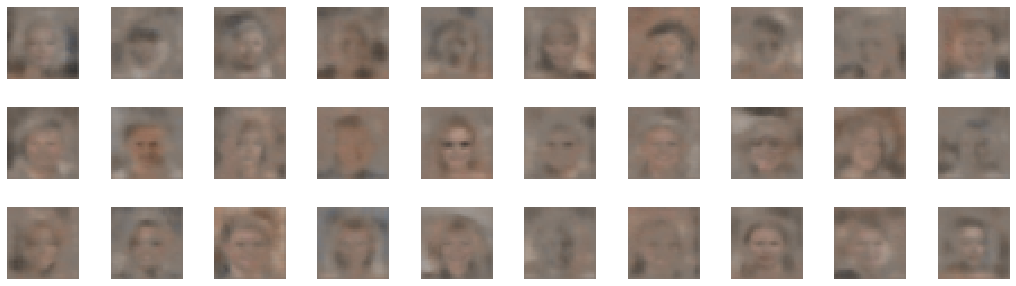

In [15]:
# Sample 30 points from the latent space and decoding them to images
import numpy as np

celeb_out_plot=vae_dir.joinpath('celeb_vae_ouput.png')

# Sample 30 points from a standard normal distribution with 200 dimensions
n_to_show = 30
znew = np.random.normal(size = (n_to_show, latent_dim))

# Pass these points to the decoder.
reconst = decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    
    # The resulting output is a 128 × 128 × 3 image
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

# Save figure
plt.savefig(celeb_out_plot)